In [299]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl

import seaborn as sns
from matplotlib.patches import Patch
sns.set_theme(style="darkgrid")
path = '../feat_importance/'

In [2]:
all_feats = pd.DataFrame(index=pd.read_pickle(path+f'uci2_dataset/featImportance-SP.pkl').features.sort_values().values)
dbs = ['sensors','uci2','bcg','ppgbp']
targets = ['SP','DP']
for db in dbs:
    for tar in targets:
        feats=pd.read_pickle(path+f'{db}_dataset/featImportance-{tar}.pkl')
        feats = feats.reset_index().rename(columns={'index':'rank'})
        feats = feats.set_index('features')
        all_feats[f'{db}_{tar}_rank'] = feats['rank']
        all_feats[f'{db}_{tar}_importance'] = feats['importance']



# Best ranked feat for SP and DP

In [3]:
all_feats[[db+'_SP_rank' for db in dbs]].mean(axis=1).sort_values()[:3]
#Amplitude of in VPG of diastolic rise (z)
#Time from systolic peak to e point (diacrotic notch).
#Time from beginning to d

SteepDiaRise     7.00
T_peak_e        16.25
T_d_norm        18.00
dtype: float64

In [4]:
all_feats[[db+'_DP_rank' for db in dbs]].mean(axis=1).sort_values()[:3]
#Time from systolic peak to e point (diacrotic notch).
#Time from systolic peak to diastolic rise (z)
#Amplitude of in VPG of diastolic rise (z)

T_peak_e          5.00
TSystoDiaRise    14.50
SteepDiaRise     24.25
dtype: float64

In [5]:
((all_feats[[db+'_SP_rank' for db in dbs]].mean(axis=1) + all_feats[[db+'_DP_rank' for db in dbs]].mean(axis=1))/2).sort_values()[:4]

T_peak_e         10.625
SteepDiaRise     15.625
T_peak_e_norm    22.500
TSystoDiaRise    25.375
dtype: float64

# Set groups

In [6]:
feat_names = all_feats.index.values
feat_names

array(['AI', 'AUCdia', 'AUCdia_norm', 'AUCsys', 'AUCsys_norm', 'DW25',
       'DW25_norm', 'DW50', 'DW50_norm', 'DW75', 'DW75_norm', 'DWdivSW25',
       'DWdivSW50', 'DWdivSW75', 'DiaRise', 'NegSteepest', 'Ratio', 'S1',
       'S1_norm', 'S2', 'S2_norm', 'S3', 'S3_norm', 'S4', 'S4_norm',
       'SQI_kurtosis', 'SQI_skew', 'SW25', 'SW25_norm', 'SW50',
       'SW50_norm', 'SW75', 'SW75_norm', 'SWaddDW25', 'SWaddDW25_norm',
       'SWaddDW50', 'SWaddDW50_norm', 'SWaddDW75', 'SWaddDW75_norm',
       'SteepDiaRise', 'Steepest', 'TNegSteepest', 'TNegSteepest_norm',
       'TSystoDiaRise', 'TSystoDiaRise_norm', 'T_a', 'T_a_norm', 'T_b',
       'T_b_norm', 'T_c', 'T_c_norm', 'T_d', 'T_d_norm', 'T_e',
       'T_e_norm', 'T_peak_a', 'T_peak_a_norm', 'T_peak_b',
       'T_peak_b_norm', 'T_peak_c', 'T_peak_c_norm', 'T_peak_d',
       'T_peak_d_norm', 'T_peak_e', 'T_peak_e_norm', 'Tc', 'Td',
       'Td_norm', 'TdiaRise', 'TdiaRise_norm', 'TdiaToEnd',
       'TdiaToEnd_norm', 'Ts', 'Ts_norm', 'Tstee

In [7]:
# point/times
times =  set([f for f in feat_names if f.startswith('T')]+
 ['ppg_max_0','ppg_min_0','vpg_max_0','vpg_min_0','apg_max_0','apg_min_0','ppg3_max_0','ppg3_min_0','ppg4_max_0','ppg4_min_0'])
amp = {'DiaRise','NegSteepest','SteepDiaRise','Steepest',
    'apg_a','apg_b','apg_c','apg_d','apg_e','ppg_a','ppg_b','ppg_c','ppg_d','ppg_e','vpg_a','vpg_b','vpg_c','vpg_d','vpg_e',}
areas = set(['S1', 'S1_norm', 'S2', 'S2_norm', 'S3', 'S3_norm', 'S4', 'S4_norm'] + [f for f in feat_names if f.startswith('AUC')])
width = {'DW25','DW25_norm','DW50','DW50_norm','DW75','DW75_norm',
         'SW25','SW25_norm','SW50','SW50_norm','SW75','SW75_norm',
        'SWaddDW25','SWaddDW25_norm','SWaddDW50','SWaddDW50_norm','SWaddDW75','SWaddDW75_norm'}

time_based = times.union(amp,areas,width)
# frequency
fft = {f for f in feat_names if 'fft' in f}
frequency = fft

# stats & operational
histograms = {f for f in feat_names if 'histogram' in f}
sdc = {f for f in feat_names if f.startswith('dsdc') or f.startswith('usdc')}
sqi = {f for f in feat_names if f.startswith('SQI')}
indices = set(['AI', 'Ratio','bd','hr_0','p2p_0','bcda','sdoo']+
              [f for f in feat_names if 'neighbor' in f]+[f for f in feat_names if f.startswith('ratio')]+
              ['DWdivSW25', 'DWdivSW50', 'DWdivSW75', 'ppg_mean_cycles_match_peak_59'])
operational = times.union(histograms,sdc,sqi,indices)

print(set(feat_names) - (histograms)-(areas)-(sdc)-indices-fft-sqi-width-times-amp)

def mapping_subg(f):
    if f in times:
        return 'Time'
    elif f in amp:
        return 'Amplitude'
    elif f in areas:
        return 'Area'
    elif f in width:
        return 'Width'
    elif f in fft:
        return 'Frequency'
    elif f in histograms:
        return 'Histogram'
    elif f in sdc:
        return 'SDC'
    elif f in sqi:
        return 'SQI'
    elif f in indices:
        return 'Indices'
    
def mapping_group(f):
    if f in time_based:
        return 'Point/Time-based'
    elif f in frequency:
        return 'Frequency-based'
    elif f in operational:
        return 'Operational'
    

set()


In [8]:
all_feats['subgroup'] = [mapping_subg(f) for f in feat_names]
all_feats['group'] = [mapping_group(f) for f in feat_names]

<AxesSubplot:>

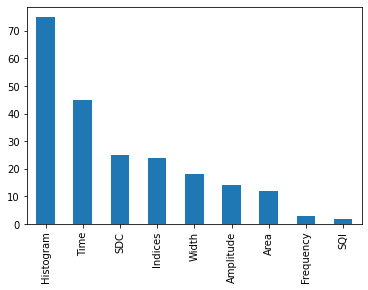

In [9]:
all_feats.subgroup.value_counts().plot.bar()

<AxesSubplot:>

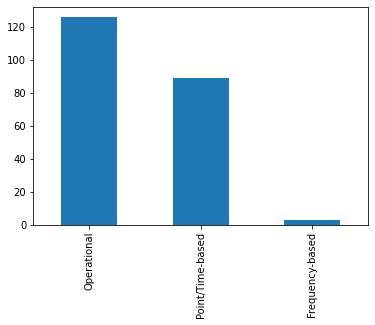

In [10]:
all_feats.group.value_counts().plot.bar()

# Importance scatter

In [11]:
all_feats

,sensors_SP_rank,sensors_SP_importance,sensors_DP_rank,sensors_DP_importance,uci2_SP_rank,uci2_SP_importance,uci2_DP_rank,uci2_DP_importance,bcg_SP_rank,bcg_SP_importance,bcg_DP_rank,bcg_DP_importance,ppgbp_SP_rank,ppgbp_SP_importance,ppgbp_DP_rank,ppgbp_DP_importance,subgroup,group
AI,105,0.004102,70,0.004854,116,0.003047,119,0.002827,123,0.001840,90,0.002449,165,0.002345,152,0.002937,Indices,Operational
AUCdia,124,0.003713,130,0.003627,138,0.002328,161,0.001895,142,0.001292,117,0.001879,36,0.004840,26,0.006602,Area,Point/Time-based
AUCdia_norm,170,0.002715,170,0.002893,81,0.004722,81,0.004413,0,0.109939,21,0.009591,2,0.055472,29,0.006209,Area,Point/Time-based
AUCsys,141,0.003381,145,0.003350,167,0.001626,165,0.001794,107,0.002261,118,0.001864,142,0.002754,150,0.002954,Area,Point/Time-based
AUCsys_norm,171,0.002699,176,0.002739,83,0.004697,90,0.004106,1,0.096638,24,0.008479,1,0.057553,32,0.005898,Area,Point/Time-based
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vpg_histogram_up_3,70,0.004846,77,0.004750,174,0.001425,177,0.001591,157,0.001031,154,0.001106,150,0.002687,130,0.003263,Histogram,Operational
vpg_histogram_up_4,24,0.006704,82,0.004599,124,0.002639,148,0.002084,188,0.000659,181,0.000740,42,0.004450,57,0.004740,Histogram,Operational
vpg_max_0,200,0.001644,201,0.001955,77,0.004820,142,0.002291,75,0.003335,103,0.002176,201,0.001280,132,0.003260,Time,Point/Time-based
vpg_max_neighbor_mean_0,143,0.003344,148,0.003330,65,0.005441,94,0.003889,90,0.002844,1,0.046300,134,0.002828,116,0.003484,Indices,Operational


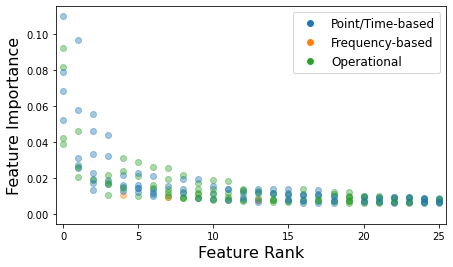

In [32]:
groups = ['Point/Time-based','Frequency-based','Operational']
colors = ['tab:blue','tab:orange','tab:green']
alpha = 0.4
plt.figure(figsize=(7,4))
for db in dbs:
    for tar in targets:
        for g,c in zip(groups,colors):
            sub_df = all_feats[all_feats.group==g]
            plt.scatter(sub_df[f'{db}_{tar}_rank'],sub_df[f'{db}_{tar}_importance'], alpha=alpha,color=c)
        plt.xlim(-0.5,25.5)
      
    
from matplotlib.lines import Line2D

legend_elements = []
#Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='g', markersize=15)
for i, (g,c) in enumerate(zip(groups,colors)):
    legend_elements+=[Line2D([0], [0], marker='o', color='w', markerfacecolor=c, label=g, alpha=1, markersize=8)]
plt.legend(handles=legend_elements,fontsize=12)
plt.xlabel('Feature Rank',fontsize=16)
plt.ylabel('Feature Importance',fontsize=16)
plt.show()

In [29]:
mpl.cm.get_cmap('tab10')(0)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

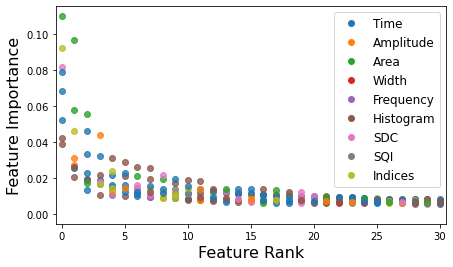

In [60]:
groups = ['Time','Amplitude','Area','Width','Frequency','Histogram','SDC','SQI','Indices']
cmap =mpl.cm.get_cmap('tab10')
#colors = ['tab:blue','tab:orange','tab:green']
alpha = 0.8
plt.figure(figsize=(7,4))
for db in dbs:
    for tar in targets:
        for i, g in enumerate(groups):
            sub_df = all_feats[all_feats.subgroup==g]
            plt.scatter(sub_df[f'{db}_{tar}_rank'],sub_df[f'{db}_{tar}_importance'], alpha=alpha,color=cmap(i/len(groups)))
        plt.xlim(-0.5,30.5)
      
    
from matplotlib.lines import Line2D

legend_elements = []
#Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='g', markersize=15)
for i, g in enumerate(groups):
    legend_elements+=[Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/len(groups)), label=g, alpha=1, markersize=8)]
plt.legend(handles=legend_elements,fontsize=12)
plt.xlabel('Feature Rank',fontsize=16)
plt.ylabel('Feature Importance',fontsize=16)
plt.show()

# Average rank for each category

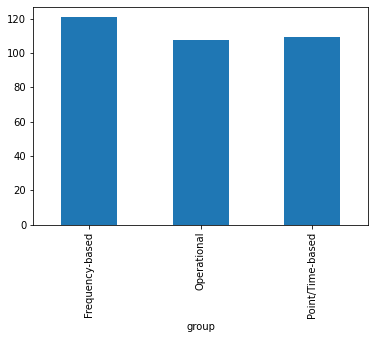

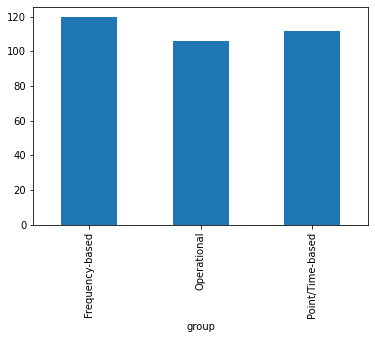

<AxesSubplot:xlabel='group'>

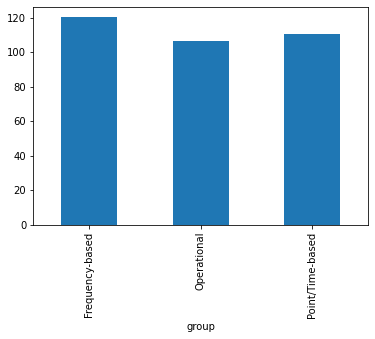

In [80]:
all_feats.groupby('group')[[c for c in all_feats.columns if 'SP_rank' in c]].mean().mean(axis=1).plot.bar()
plt.show()
all_feats.groupby('group')[[c for c in all_feats.columns if 'DP_rank' in c]].mean().mean(axis=1).plot.bar()
plt.show()
all_feats.groupby('group')[[c for c in all_feats.columns if '_rank' in c]].mean().mean(axis=1).plot.bar()

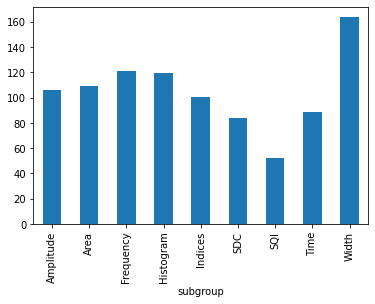

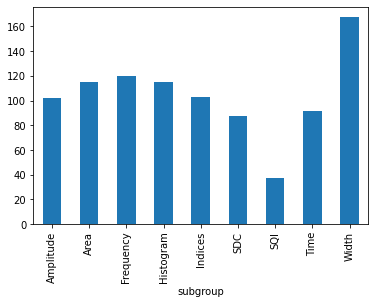

<AxesSubplot:xlabel='subgroup'>

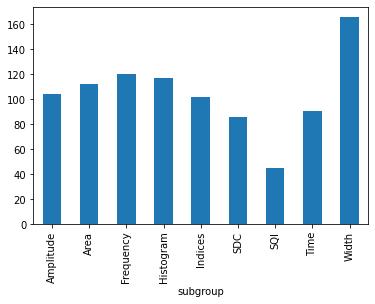

In [81]:
all_feats.groupby('subgroup')[[c for c in all_feats.columns if 'SP_rank' in c]].mean().mean(axis=1).plot.bar()
plt.show()
all_feats.groupby('subgroup')[[c for c in all_feats.columns if 'DP_rank' in c]].mean().mean(axis=1).plot.bar()
plt.show()
all_feats.groupby('subgroup')[[c for c in all_feats.columns if '_rank' in c]].mean().mean(axis=1).plot.bar()

# Among selected, percentage for each category

In [97]:
from omegaconf import OmegaConf
algs = ['lgb','svr','rf','mlp','ada']
num_feats = all_feats.shape[0]

In [154]:
df_SP = []
df_DP = []

for alg in algs:
    for db in dbs:
        conf = OmegaConf.load(f'../code/train/core/config/ml/{alg}/{alg}_{db}_SP.yaml')
        conf.param_loader.rate_features
        n_sel = int(num_feats*conf.param_loader.rate_features)
        df_temp = all_feats.sort_values(f'{db}_SP_rank').iloc[:n_sel][[f'{db}_SP_rank',f'{db}_SP_importance','group','subgroup']]
        df_temp = df_temp.rename(columns = {f'{db}_SP_rank':'rank',f'{db}_SP_importance':'importance'})
        df_SP.append(df_temp)
        
        conf = OmegaConf.load(f'../code/train/core/config/ml/{alg}/{alg}_{db}_DP.yaml')
        conf.param_loader.rate_features
        n_sel = int(num_feats*conf.param_loader.rate_features)
        df_temp = all_feats.sort_values(f'{db}_DP_rank').iloc[:n_sel][[f'{db}_DP_rank',f'{db}_DP_importance','group','subgroup']]
        df_temp = df_temp.rename(columns = {f'{db}_DP_rank':'rank',f'{db}_DP_importance':'importance'})
        df_DP.append(df_temp)
        
df_all = pd.concat(df_SP+df_DP)
df_SP = pd.concat(df_SP)
df_DP = pd.concat(df_DP)


In [157]:
group_stats = pd.DataFrame()
group_stats['avg_rank_SP'] = df_SP.groupby('group')['rank'].mean()
group_stats['avg_importance_SP'] = df_SP.groupby('group')['importance'].mean()
group_stats['avg_percentage_SP'] = df_SP.value_counts('group')/len(df_SP)*100

group_stats['avg_rank_DP'] = df_DP.groupby('group')['rank'].mean()
group_stats['avg_importance_DP'] = df_DP.groupby('group')['importance'].mean()
group_stats['avg_percentage_DP'] = df_DP.value_counts('group')/len(df_DP)*100

group_stats['avg_rank_all'] = df_all.groupby('group')['rank'].mean()
group_stats['avg_importance_all'] = df_all.groupby('group')['importance'].mean()
group_stats['avg_percentage_all'] = df_all.value_counts('group')/len(df_all)*100

In [158]:
group_stats

,avg_rank_SP,avg_importance_SP,avg_percentage_SP,avg_rank_DP,avg_importance_DP,avg_percentage_DP,avg_rank_all,avg_importance_all,avg_percentage_all
group,,,,,,,,,
Frequency-based,44.454545,0.006943,1.851852,22.333333,0.007845,2.218115,36.647059,0.007262,1.966455
Operational,52.916431,0.007694,59.427609,32.605096,0.012124,58.040665,46.663725,0.009057,58.993638
Point/Time-based,54.521739,0.011963,38.720539,21.883721,0.015050,39.741220,44.125926,0.012946,39.039907


In [159]:
sub_stats = pd.DataFrame()
sub_stats['avg_rank_SP'] = df_SP.groupby('subgroup')['rank'].mean()
sub_stats['avg_importance_SP'] = df_SP.groupby('subgroup')['importance'].mean()
sub_stats['avg_percentage_SP'] = df_SP.value_counts('subgroup')/len(df_SP)*100

sub_stats['avg_rank_DP'] = df_DP.groupby('subgroup')['rank'].mean()
sub_stats['avg_importance_DP'] = df_DP.groupby('subgroup')['importance'].mean()
sub_stats['avg_percentage_DP'] = df_DP.value_counts('subgroup')/len(df_DP)*100

sub_stats['avg_rank_all'] = df_all.groupby('subgroup')['rank'].mean()
sub_stats['avg_importance_all'] = df_all.groupby('subgroup')['importance'].mean()
sub_stats['avg_percentage_all'] = df_all.value_counts('subgroup')/len(df_all)*100

In [160]:
sub_stats

,avg_rank_SP,avg_importance_SP,avg_percentage_SP,avg_rank_DP,avg_importance_DP,avg_percentage_DP,avg_rank_all,avg_importance_all,avg_percentage_all
subgroup,,,,,,,,,
Amplitude,48.647887,0.010180,5.976431,23.736842,0.011883,7.024030,39.963303,0.010774,6.304222
Area,48.449275,0.028769,5.808081,30.833333,0.010516,3.327172,44.804598,0.024992,5.031810
Frequency,44.454545,0.006943,1.851852,22.333333,0.007845,2.218115,36.647059,0.007262,1.966455
Histogram,53.942065,0.007349,33.417508,32.768786,0.011403,31.977819,47.515789,0.008579,32.967033
Indices,49.782946,0.010842,10.858586,30.537037,0.012415,9.981516,44.103825,0.011306,10.584153
SDC,54.450000,0.006154,13.468013,38.882353,0.014337,12.569316,49.807018,0.008595,13.186813
SQI,40.500000,0.006545,1.683502,14.526316,0.009941,3.512015,27.846154,0.008200,2.255639
Time,49.844595,0.009188,24.915825,19.873418,0.016404,29.205176,39.414097,0.011699,26.257953
Width,147.041667,0.003149,2.020202,108.000000,0.003151,0.184843,145.480000,0.003149,1.445922


In [241]:
o = ['Time','Amplitude','Area','Width','Frequency','Histogram','SDC','SQI','Indices']

In [296]:
cmap = mpl.cm.get_cmap('tab20c')
my_pal = {'Time':cmap(0), 'Amplitude':cmap(1),'Area':cmap(2),'Width':cmap(3),
          'Histogram':cmap(4),'SDC':cmap(5),'SQI':cmap(6),'Indices':cmap(7),
          'Frequency':cmap(8)}

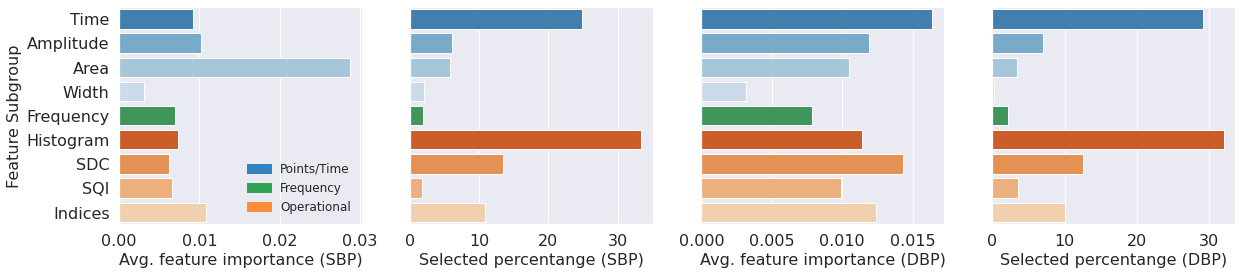

In [319]:
fig, axs = plt.subplots(1,4, figsize=(20,4))
sns.barplot(x ='avg_importance_SP' , y=sub_stats.index, data=sub_stats,ax=axs[0], order = o, palette=my_pal)
sns.barplot(x ='avg_percentage_SP' , y=sub_stats.index, data=sub_stats,ax=axs[1], order = o, palette=my_pal)
sns.barplot(x ='avg_importance_DP' , y=sub_stats.index, data=sub_stats,ax=axs[2], order = o, palette=my_pal)
sns.barplot(x ='avg_percentage_DP' , y=sub_stats.index, data=sub_stats,ax=axs[3], order = o, palette=my_pal)

for i, ax in enumerate(axs[1:]):
    ax.set_ylabel('')
    ax.set_yticklabels('')
    #axs[0].tick_params(axis='y', which='major', labelsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
axs[0].set_ylabel('Feature Subgroup', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[0].set_xlabel('Avg. feature importance (SBP)', fontsize=16)
axs[2].set_xlabel('Avg. feature importance (DBP)', fontsize=16)
axs[1].set_xlabel('Selected percentange (SBP)', fontsize=16)
axs[3].set_xlabel('Selected percentange (DBP)', fontsize=16)



legend_elements = [Patch(facecolor=cmap(0), edgecolor=cmap(0), label='Points/Time'),
                   Patch(facecolor=cmap(8), edgecolor=cmap(8), label='Frequency'),
                   Patch(facecolor=cmap(5), edgecolor=cmap(5), label='Operational')]

axs[0].legend(handles=legend_elements, fontsize=12,frameon=False)
plt.savefig('fig-BP/feats_imp.pdf',format='pdf', bbox_inches='tight')

In [302]:
cmap(0)

(0.19215686274509805, 0.5098039215686274, 0.7411764705882353, 1.0)